# Complexity and Chaos: Simulating Flocks of Birds!

<a target="_blank" href="https://colab.research.google.com/github/riacheruvu/wwcode-challenge-2024">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

There are many ways to approach complexity and chaos theory and its practical applications. A fascinating approach is looking at simulating the physical activity of complex and chaotic systems, and trying to predict/simulate their elements.

For this experiment, we'll look at a specific kind of simulation: The flocking behavior of birds! I'm using a short snippet from The Alan Turing Institute's course "Research Software Engineering with Python" to [simulate the birds](https://alan-turing-institute.github.io/rse-course/html/index.html) with Python!

I've added my thoughts and learnings throughout this notebook and via code comments, breaking down my understanding of the process.

## Quick definitions

We call our simulated birds, **boids**.

Each bird/boid has an:
- x velocity
- y velocity
- x position
- y position

## Step 0: Setup!

Before we start simulating the behavior of birds through our boids, we want to do a few things to setup:
1. Define the number of boids
2. Put the boids in random initial positions they'll start from, based on a range we define.
3. Control the size/edges of our simulation area.
4. Define the starting velocity randomly!

We're going to define a function `new_flock()` function for adding this randomness and the limits of our x-axis and y-axis.

In [2]:
import numpy as np

#Define the number of boids
boid_count = 10

#Define edges of simulation area for our simulation that we won't bypass
#We'll revisit this at the end of the notebook
limits = np.array([2000, 2000])

In [3]:
#Used to generate new positions and velocities based on the range we define for the generation
def new_flock(count, lower_limits, upper_limits):
    width = upper_limits - lower_limits
    return lower_limits[:, np.newaxis] + np.random.rand(2, count) * width[:, np.newaxis]

We can use the same new_flock() function to generate the initial positions and starting velocities!

In [4]:
#Generate positions
#Positions will vary between 100 and 200 in the x axis,
#and 900 and 1100 in the y axis.
positions = new_flock(boid_count, np.array([100, 900]), np.array([200, 1100]))
positions

array([[ 124.87595605,  188.10799815,  186.47522877,  112.98045663,
         153.72814899,  123.06351657,  149.07195537,  170.10370349,
         170.58891259,  170.79065983],
       [1042.29650469, 1053.03961565, 1066.6784219 , 1092.21000259,
        1054.41098482,  919.84879706,  969.10545037,  917.86290702,
         948.87975949, 1020.59003474]])

In [5]:
#Generate velocities
#X velocities will vary between 0 and 10,
#and y velocities over -20,20
velocities = new_flock(boid_count, np.array([0, -20]), np.array([10, 20]))
velocities

array([[  8.38188829,   5.48631883,   5.61509311,   2.90551652,
          0.30325115,   6.69846628,   4.21334781,   2.55488304,
          3.84119321,   4.45928768],
       [ 18.35922852,  -8.0320807 ,  16.61809543, -11.93423277,
         10.5404006 , -15.46779131, -18.10862729,   3.46008116,
         14.35492348,  12.19780997]])

Now what? If we want to have the whole flock start moving, we simply perform

```
positions += velocities
```

In [6]:
positions += velocities
positions

array([[ 133.25784434,  193.59431697,  192.09032188,  115.88597315,
         154.03140014,  129.76198285,  153.28530318,  172.65858653,
         174.43010581,  175.24994751],
       [1060.65573321, 1045.00753495, 1083.29651734, 1080.27576982,
        1064.95138542,  904.38100575,  950.99682308,  921.32298819,
         963.23468297, 1032.7878447 ]])

Let's see how to put this into practice to update boids' movements, by getting into our steps.

## Step 1: Coherence

Each boid is steering itself gently toward [the center of mass of the other boids](https://vanhunteradams.com/Pico/Animal_Movement/Boids-algorithm.html#Cohesion) that are within its visible range.

We'll shortcut this by saying our boids need to fly towards the "middle".

First, let's define a function `update_boids()` step by step.

In [7]:
def update_boids(positions, velocities):

    #Step 1--------------------
    #Goal: Birds are steering towards the middle
    #We get the middle of the positions
    #and calculate the direction to the middle of the cluster
    #as well as update the velocities
    move_to_middle_strength = 0.01
    middle = np.mean(positions, 1)
    direction_to_middle = positions - middle[:, np.newaxis]
    velocities -= direction_to_middle * move_to_middle_strength
    ... #full, final function is in step 3!

## Step 2: Separation

Each boid avoids running into other boids by steering away if it’s about to hit a boid.

Now we need to get the distances between each boid.

We also need to find boids that are too close. If the boids are too close, we need to find the direction and distance to these boids and steer away.

This snippet is the code under `#Step 2---` in the below code block!

In [8]:
def update_boids(positions, velocities):

    #Step 1--------------------
    #Goal: Birds are steering towards the middle
    #We get the middle of the positions
    #and calculate the direction to the middle of the cluster
    #as well as update the velocities
    move_to_middle_strength = 0.01
    middle = np.mean(positions, 1)
    direction_to_middle = positions - middle[:, np.newaxis]
    velocities -= direction_to_middle * move_to_middle_strength

    #Step 2--------------------
    #Goal: Seperation - birds shouldn't run into each other
    #Get the seperations between boids for X-distances
    #and Y-distances
    separations = positions[:, np.newaxis, :] - positions[:, :, np.newaxis]
    squared_displacements = separations * separations
    #square_distances is giving the distances between each bird
    square_distances = np.sum(squared_displacements, 0)
    #Next, find boids that are far away from each other with the alert_distance threshold
    #We're indirectly doing this to find birds that are too close
    alert_distance = 100
    far_away = square_distances > alert_distance
    #For boids that are too close, get the direction distances
    separations_if_close = np.copy(separations)
    #If they're far away, set separations_if_close's values to 0
    #for the applicable values.
    separations_if_close[0, :, :][far_away] = 0
    separations_if_close[1, :, :][far_away] = 0
    #Fly away from the too close boids
    velocities += np.sum(separations_if_close, 1)
    ... #full, final function is in step 3!

## Step 3: Alignment

Each boid needs to match the speed and direction of its surrounding boids.

In [9]:
def update_boids(positions, velocities):

    #Step 1--------------------
    #Goal: Birds are steering towards the middle
    #We get the middle of the positions
    #and calculate the direction to the middle of the cluster
    #as well as update the velocities
    move_to_middle_strength = 0.01
    middle = np.mean(positions, 1)
    direction_to_middle = positions - middle[:, np.newaxis]
    velocities -= direction_to_middle * move_to_middle_strength

    #Step 2--------------------
    #Goal: Seperation - birds shouldn't run into each other
    #Get the seperations between boids for X-distances
    #and Y-distances
    separations = positions[:, np.newaxis, :] - positions[:, :, np.newaxis]
    squared_displacements = separations * separations
    #square_distances is giving the distances between each bird
    square_distances = np.sum(squared_displacements, 0)
    #Next, find boids that are far away from each other with the alert_distance threshold
    #We're indirectly doing this to find birds that are too close
    alert_distance = 100
    far_away = square_distances > alert_distance
    #For boids that are too close, get the direction distances
    separations_if_close = np.copy(separations)
    #If they're far away, set separations_if_close's values to 0
    #for the applicable values.
    separations_if_close[0, :, :][far_away] = 0
    separations_if_close[1, :, :][far_away] = 0
    #Fly away from the too close boids
    velocities += np.sum(separations_if_close, 1)

    #Step 3--------------------
    #Goal: Alignment (matching speed and direction of close boids)
    #Get the difference in velocities between boids for X- and Y- distances
    velocity_differences = velocities[:, np.newaxis, :] - velocities[:, :, np.newaxis]
    #Set parameters around formation's distance and strength (see below for usage)
    formation_flying_distance = 10000
    formation_flying_strength = 0.125
    #Next, find boids that are far, comparing with the flying distance of the formation
    #Indirectly, here we're trying to find boids within the formation_flying_distance:
    #Only these boids will impact the velocity
    very_far = square_distances > formation_flying_distance
    #Create a copy of differences
    #Only find the differences in velocity, if boids are within the distance/close
    velocity_differences_if_close = np.copy(velocity_differences)
    #If they're far, set the velocity_differences_if_close' values to 0
    velocity_differences_if_close[0, :, :][very_far] = 0
    velocity_differences_if_close[1, :, :][very_far] = 0
    #Update the velocity based on: the average velocities of the boids that are close,
    #multipled by the formation's flying strength
    velocities -= np.mean(velocity_differences_if_close, 1) * formation_flying_strength

    #Move our flock!
    positions += velocities

## Visualize!

To visualize our boids moving together, let's also define an `animate()` function that calles our `update_boids()` function, and updates the figure for each time step.

In [10]:
def animate(frame):
    #Run update boids function to move the flock
    #The figure is updated for each time step
    update_boids(positions, velocities)
    scatter.set_offsets(positions.transpose())

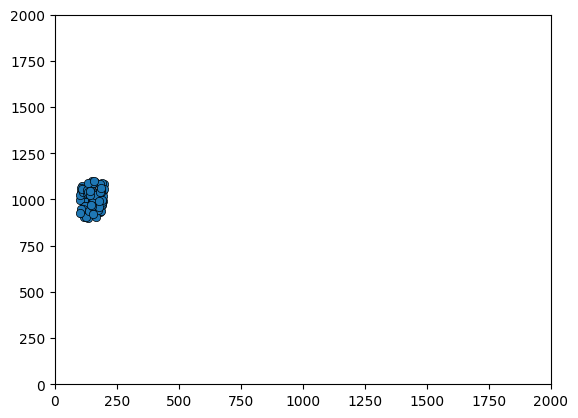

In [11]:
#Imports for visualizing in the notebook
from IPython.display import HTML
from matplotlib import animation
from matplotlib import pyplot as plt

#Define positions and velocities
positions = new_flock(100, np.array([100, 900]), np.array([200, 1100]))
velocities = new_flock(100, np.array([0, -20]), np.array([10, 20]))
#Define limits of simulation area for our x-axis and y-axis
limits = np.array([2000, 2000])

#Define an empty figure
figure = plt.figure()
#Get the starting figure ready which will then keep getting updated
#Defining the simulation's limits with the xlim and ylim parameters
axes = plt.axes(xlim=(0, limits[0]), ylim=(0, limits[1]))
scatter = axes.scatter(
    positions[0, :], positions[1, :], marker="o", edgecolor="k", lw=0.5
)

Note: This final block is the animation! It may take some time to load (~30 seconds).

**Once it loads, you can press the right arrow to start the animation.**

In [14]:
#Call FuncAnimation, and specify how many frames we want for the animation
anim = animation.FuncAnimation(figure, animate, frames=200, interval=50)

#Visualize our flock in the browser!
HTML(anim.to_jshtml())

At this point, we have our fundamental rules for the boids set in place! What happens if we introduce a predator? The flock will move in different ways.

We could expand upon our simulations to reflect the even more complex behavioral systems of birds in next steps!